# Image Recognition Project - Structural Defect Recognition
---------------------------------------------------------------
## Data Visualisation

### Section Objectives
 - Complete the project objective and answer the business requirements by training the -

 --------------------------------------------------------------

## Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
import joblib

sns.set_style("whitegrid")

## Setting Working Directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspaces/ML_Project_Image_Recognition')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/ML_Project_Image_Recognition'

## Setting Input and Output Directories

### Input:

In [6]:
base_path = 'inputs/cracks_dataset_new' 

train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

datasets = os.listdir(train_path)
print("Detected datasets in training set:", datasets)


Detected datasets in training set: ['Decks', 'Pavements', 'Walls']


### Output:

In [7]:
version = 'v1'
output_path = os.path.join('outputs', version)

if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"Created output folder at: {output_path}")
else:
    print(f"Output folder already exists: {output_path}")

Output folder already exists: outputs/v1


Setting Dataset Labels

In [8]:
dataset_labels = {}

for dataset in datasets:
    dataset_path = os.path.join(train_path, dataset)
    if os.path.isdir(dataset_path):
        labels = os.listdir(dataset_path)
        dataset_labels[dataset] = labels

print("Dataset → Classes:")
for k, v in dataset_labels.items():
    print(f"• {k}: {v}")

Dataset → Classes:
• Decks: ['Cracked', 'Non-cracked']
• Pavements: ['Cracked', 'Non-cracked']
• Walls: ['Cracked', 'Non-cracked']


In [9]:
def plot_image_dimensions(dataset_name):
    dim1, dim2 = [], []
    print(f"\n🔍 Processing image sizes for: {dataset_name}")

    for label in dataset_labels[dataset_name]:  
        class_path = os.path.join(train_path, dataset_name, label)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = imread(img_path)
                h, w = img.shape[:2]
                dim1.append(h)
                dim2.append(w)
            except:
                continue  

    fig, ax = plt.subplots()
    sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
    ax.set_xlabel("Width (px)")
    ax.set_ylabel("Height (px)")
    ax.set_title(f"Image Size Distribution — {dataset_name}")

    mean_w = int(np.mean(dim2))
    mean_h = int(np.mean(dim1))
    ax.axvline(mean_w, color='r', linestyle='--', label=f"Mean Width: {mean_w}px")
    ax.axhline(mean_h, color='g', linestyle='--', label=f"Mean Height: {mean_h}px")
    plt.legend()
    plt.show()

    return mean_h, mean_w


🔍 Processing image sizes for: Walls


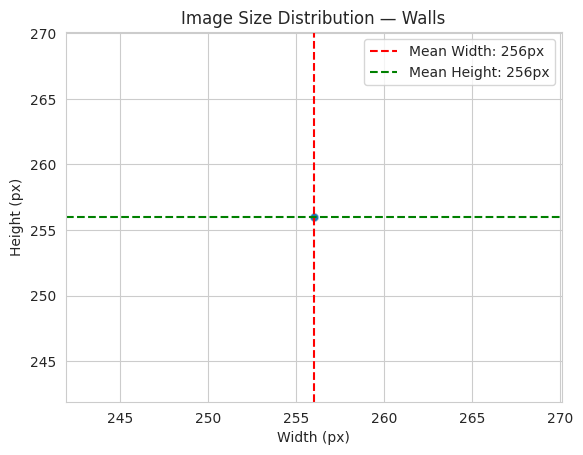


🔍 Processing image sizes for: Decks


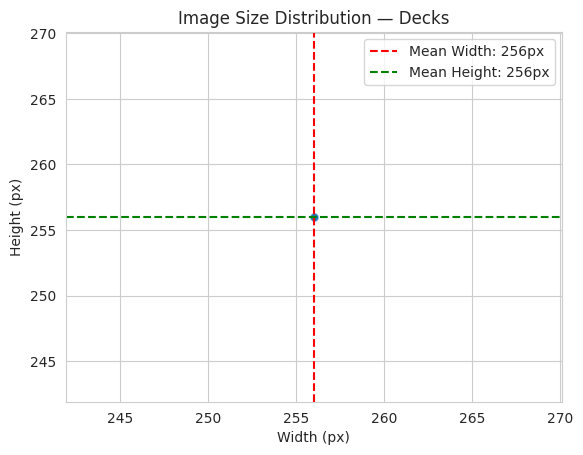


🔍 Processing image sizes for: Pavements


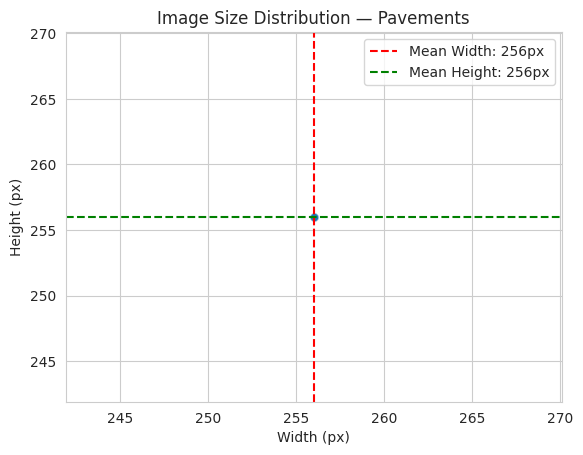

In [10]:
walls_shape = plot_image_dimensions('Walls')
decks_shape = plot_image_dimensions('Decks')
pavements_shape = plot_image_dimensions('Pavements')

In [11]:
image_shape = (256, 256, 3)
print("Image shape to be saved:", image_shape)

joblib.dump(image_shape, os.path.join(output_path, "image_shape.pkl"))
print(f"Image shape saved to: {output_path}/image_shape.pkl")

Image shape to be saved: (256, 256, 3)
Image shape saved to: outputs/v1/image_shape.pkl


Function to load images into Array

In [12]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(data_dir, dataset_name, image_shape=(256, 256), n_images_per_label=30):
    X, y = [], []
    labels = dataset_labels[dataset_name]

    for label in labels:
        label_path = os.path.join(data_dir, dataset_name, label)
        counter = 0

        for file_name in os.listdir(label_path):
            if counter >= n_images_per_label:
                break

            img_path = os.path.join(label_path, file_name)
            try:
                img = image.load_img(img_path, target_size=image_shape)
                img_array = image.img_to_array(img) / 255.0 
                X.append(img_array)
                y.append(label)
                counter += 1
            except:
                continue  

    X = np.array(X)
    y = np.array(y)
    return X, y

Loading into Array

In [13]:
X_walls, y_walls = load_image_as_array(train_path, dataset_name='Walls', image_shape=(256, 256), n_images_per_label=30)

print("Loaded shape:", X_walls.shape)
print("Labels:", np.unique(y_walls))

Loaded shape: (60, 256, 256, 3)
Labels: ['Cracked' 'Non-cracked']


In [14]:
def plot_mean_variability_per_labels(X, y, dataset_name, figsize=(12, 5), save_image=False):
    for label in np.unique(y):
        sns.set_style("white")

        mask = y == label
        images = X[mask]

        avg_img = np.mean(images, axis=0)
        std_img = np.std(images, axis=0)

        print(f"Dataset: {dataset_name} | Class: {label}")
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].imshow(avg_img)
        axes[0].set_title(f"Mean Image — {label}")
        axes[1].imshow(std_img)
        axes[1].set_title(f"Variability — {label}")

        for ax in axes:
            ax.axis('off')

        plt.tight_layout()

        if save_image:
            filename = f"{output_path}/mean_std_{dataset_name}_{label}.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"Saved to {filename}")
        else:
            plt.show()



 Loading and visualizing: Walls
Dataset: Walls | Class: Cracked
Saved to outputs/v1/mean_std_Walls_Cracked.png
Dataset: Walls | Class: Non-cracked
Saved to outputs/v1/mean_std_Walls_Non-cracked.png

 Loading and visualizing: Decks
Dataset: Decks | Class: Cracked
Saved to outputs/v1/mean_std_Decks_Cracked.png
Dataset: Decks | Class: Non-cracked
Saved to outputs/v1/mean_std_Decks_Non-cracked.png

 Loading and visualizing: Pavements
Dataset: Pavements | Class: Cracked
Saved to outputs/v1/mean_std_Pavements_Cracked.png
Dataset: Pavements | Class: Non-cracked
Saved to outputs/v1/mean_std_Pavements_Non-cracked.png


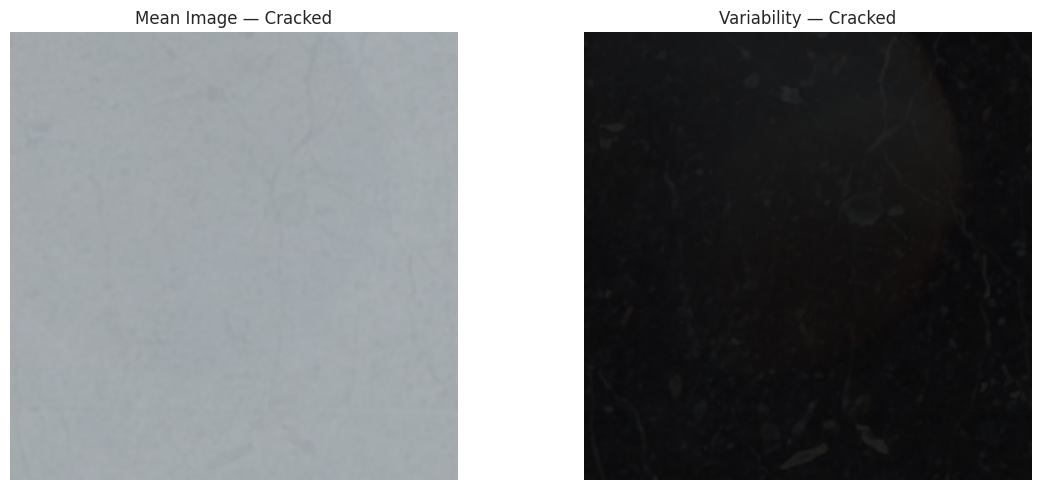

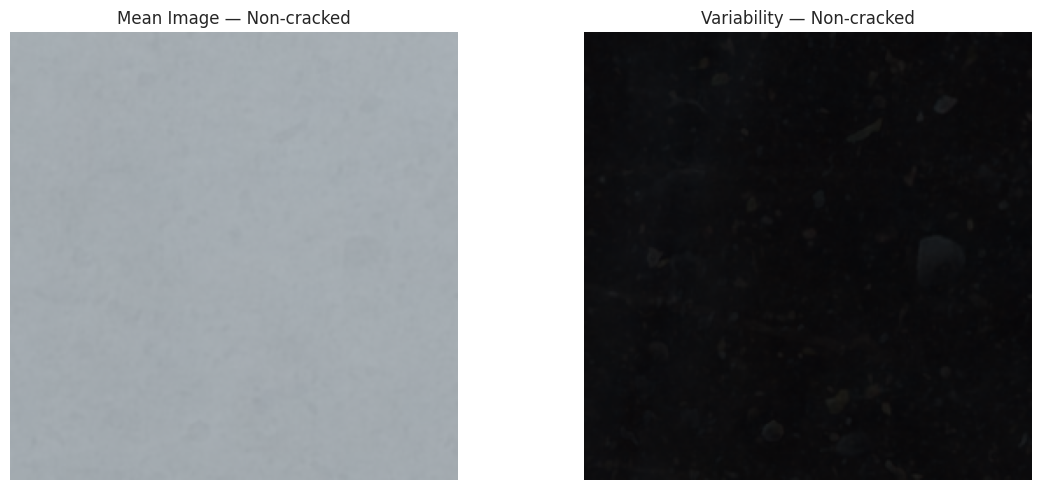

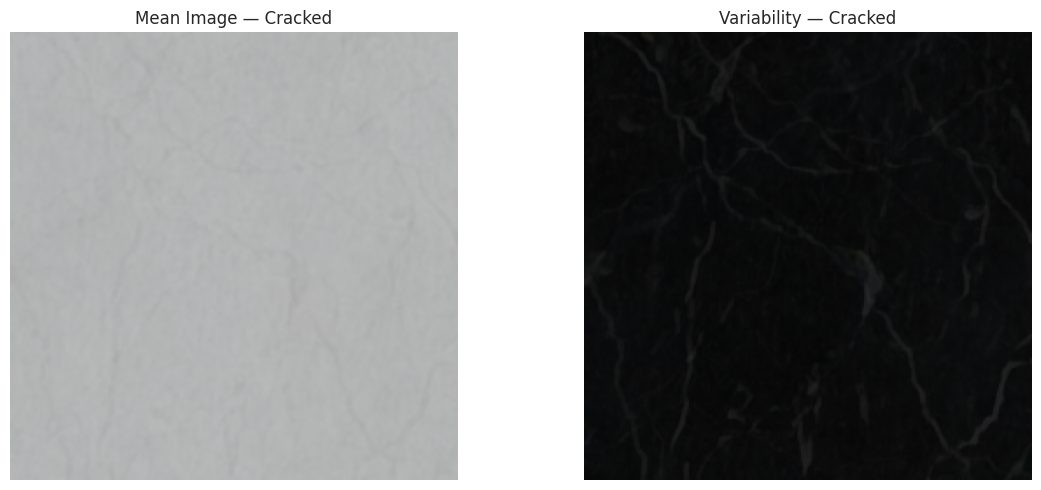

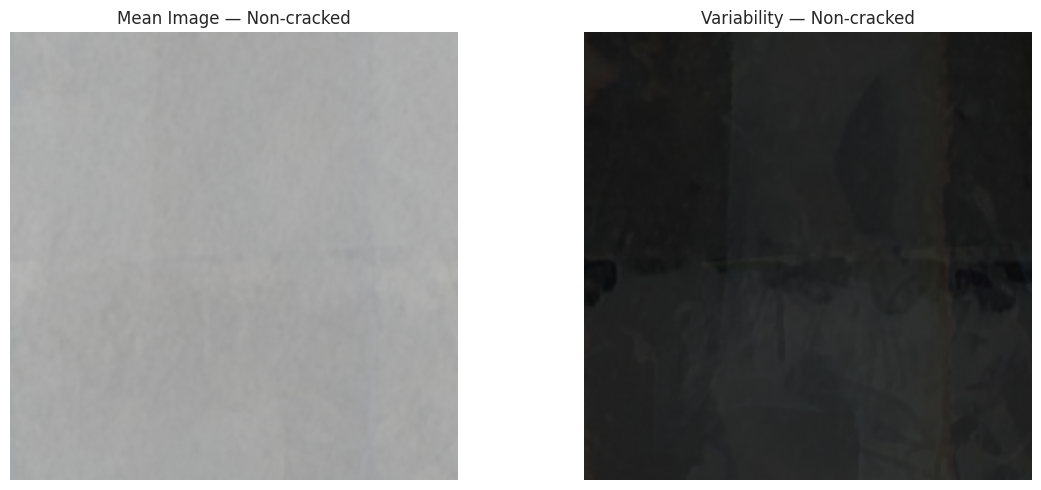

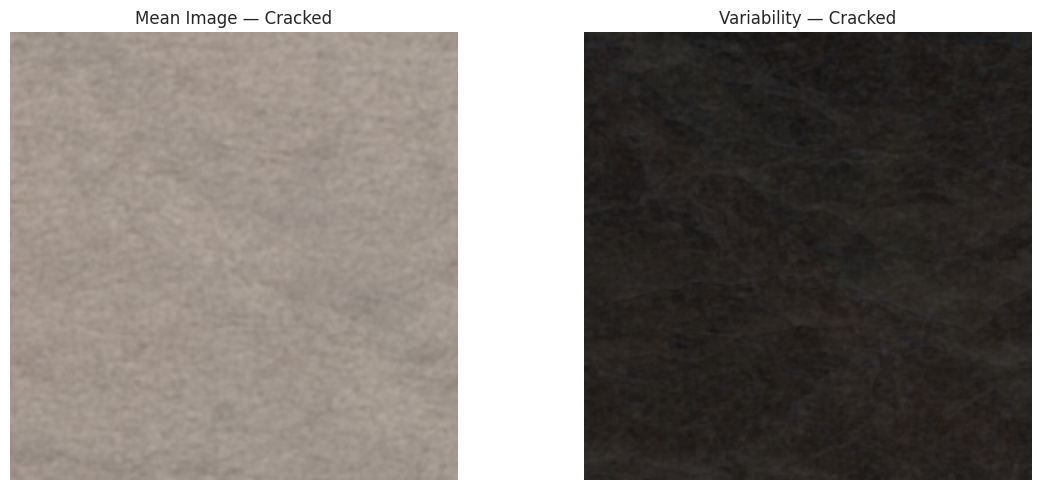

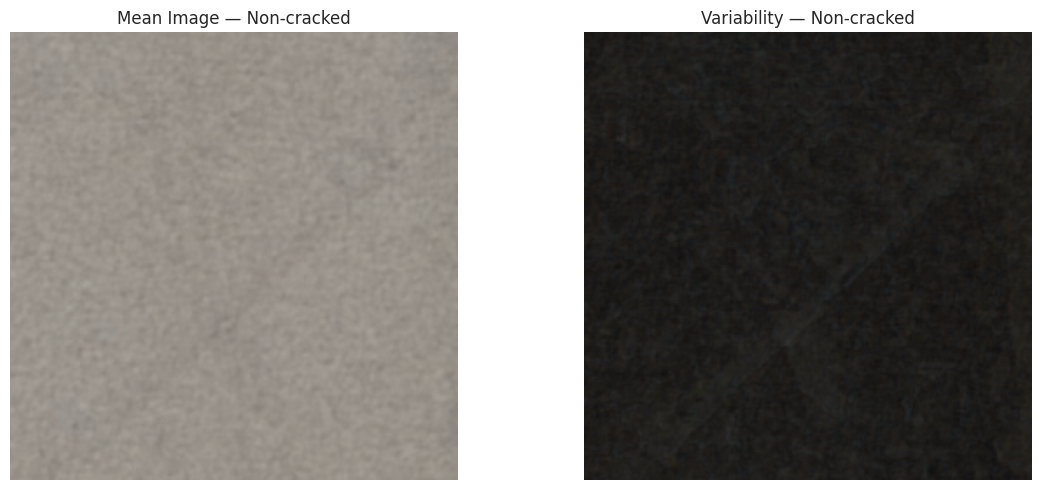

In [15]:
for dataset in ['Walls', 'Decks', 'Pavements']:
    print(f"\n Loading and visualizing: {dataset}")
    X, y = load_image_as_array(train_path, dataset_name=dataset, image_shape=(256, 256), n_images_per_label=30)
    plot_mean_variability_per_labels(X=X, y=y, dataset_name=dataset, save_image=True)